In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

# Selection model

### Data prep

In [3]:
words = pd.read_csv('./data/words.csv')

In [4]:
# Prepare a model for the finger offset when tapping different keys
offset_keys = pd.read_csv('./data/key_offset.csv',index_col=0)
def get_offset(x):
    effort = 0
    for c in x:
        if c in offset_keys.index:
            effort += offset_keys.loc[c,'offset_one_thumb']
    return effort

In [5]:
mask = words.ite.isin(['none','predict'])
mask &= words.word_length > 1
mask &= words.word_length < 14
mask &= (words.word == words.ite_input) | (words.ite == 'none') # Only words which are the same as the input
data = words.loc[mask,['word','word_length','freq','ite2','iki','type','ite_input_prev']].copy()

# Add features
data['leadup_length'] = data.word_length # When no ite is used, the leadup length is just the length of the word
data.loc[data.ite2.notna(),'leadup_length'] = data.ite_input_prev.str.len() # When an ite is used, the leadup length is based on the previous string
data['is_contraction'] = (data.type == 'contraction').astype(float)
data['is_capitalized'] = (data.type == 'proper').astype(float)
data.drop('type',axis=1,inplace=True) # Remove the "type" column, we no longer need it
data.drop('ite_input_prev',axis=1,inplace=True) # Remove the "input_prev" column, we no longer need it

# Remove the less common substrategies
data.ite2 = data.ite2.fillna('none') # When no ite is used, mark as "none"
data = data.loc[data.ite2.isin(['completion','correction','contraction','capitalization','prediction','none'])] # Ignore the uncommon strategies

# Add features that are based on the normally typed instances of the word
data2 = words.loc[words.ite == 'none'].groupby('word').filter(lambda x: x.shape[0] > 20) # Only words that were typed normally more than 20 times
data['base_speed'] = data.word.map(data2.groupby('word').iki_letters.mean()) # Use letter-only speed
data['touch_offset'] = data.word.map(get_offset) / data.word_length # Normalize the offset based on word length
data['backspaces'] = data.word.map(data2.groupby('word').n_backspace.mean())

# Drop any nan
data = data.dropna()

# Rename
data = data.rename(columns={'iki':'leadup_speed'})

# Transform to get better distributions
data.freq = np.log10(data.freq)
data.leadup_speed = data.leadup_speed.apply(np.reciprocal)*1000
data.base_speed = data.base_speed.apply(np.reciprocal)*1000

# Remove outliers
data = data.loc[data.touch_offset < 1].copy()
data = data.loc[data.leadup_speed < 20].copy()

# Finalize
data = data.set_index('word')

In [6]:
data.ite2.value_counts()

none              740069
completion         19599
correction          9190
prediction          1494
contraction          647
capitalization       528
Name: ite2, dtype: int64

### Training

In [7]:
# Preprocess X
X = data.loc[:,data.columns != 'ite2'].copy()
X.word_length = X.word_length.astype(float)
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X.is_contraction = data.is_contraction # Go back to binary
X.is_capitalized = data.is_capitalized # Go back to binary

# Preprocess y
y = data['ite2'].copy()

# Split data
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.1,random_state=1)

# Add constant
X_train = sm.add_constant(X_train) # TODO: do we want to include this?

In [8]:
params = []
pvalues = []
errors = []
params_disp = []

# For each substrategy, train a binary logistic regression
for i in y_train.sort_values().unique():
    # Check the substrategy, depending on it we will ignore certain columns
    if i == 'prediction':
        c = ['const','word_length','freq','is_contraction','is_capitalized','base_speed','touch_offset','backspaces']
    elif i in ['capitalization','contraction']:
        c = ['const','word_length','freq','is_contraction','is_capitalized','base_speed','touch_offset','backspaces','leadup_speed']
    else:    
        c = X_train.columns # All columns
    if i == 'none':
        continue # Remove this line to see the "none" column
    
    # Fit the regression
    model = sm.Logit((y_train == i).astype(float),X_train.loc[:,c])
    results = model.fit(method='lbfgs',maxiter=1000)
    
    # Save the values
    params.append(results.params.to_frame(i))
    pvalues.append(results.pvalues.to_frame(i))
    errors.append(results.bse.to_frame(i))

# Create dataframe
params = pd.concat(params,axis=1,sort=False)
pvalues = pd.concat(pvalues,axis=1,sort=False)
errors = pd.concat(errors,axis=1,sort=False)

### Coefficients

In [9]:
def to_asterix(x):
    if x <= 0.01:
        return '***'
    elif x <= 0.05:
        return '**'
    elif x <= 0.1:
        return '*'
    else:
        return ''

# Create a nice display of the parameters (significance, errors, etc.)
params_disp = pd.DataFrame()
for c in params.columns:
    for i in params.index:
        param = params.loc[i,c]
        p = pvalues.loc[i,c]
        e = errors.loc[i,c]
        if np.isnan(param):
            params_disp.loc[i,c] = 'N/A'
        else:
            params_disp.loc[i,c] = '{}{}\n({})'.format(
                str(round(param,2)),
                to_asterix(p),
                str(round(e,2))
            ) 

In [10]:
from IPython.display import display

# Assuming the variable df contains the relevant DataFrame
display(params_disp.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

,capitalization,completion,contraction,correction,prediction
const,-11.36*** (0.24),-8.35*** (0.07),-12.55*** (0.61),-5.84*** (0.03),-6.48*** (0.04)
word_length,0.37*** (0.05),5.53*** (0.04),-0.22* (0.13),0.77*** (0.02),0.55*** (0.05)
freq,-0.62*** (0.09),-0.4*** (0.03),0.2 (0.14),-0.38*** (0.02),0.56*** (0.05)
is_contraction,-0.67 (1.72),0.32*** (0.12),11.52*** (0.66),-0.84*** (0.12),0.31 (1.05)
is_capitalized,5.61*** (0.24),-0.25*** (0.09),-1.36 (10.58),-0.55*** (0.06),0.66*** (0.25)
base_speed,0.45*** (0.07),0.04 (0.02),-0.22*** (0.08),0.13*** (0.02),0.15*** (0.04)
touch_offset,0.15*** (0.05),0.05*** (0.02),0.07 (0.07),-0.04*** (0.01),-0.1*** (0.03)
backspaces,-0.02 (0.04),-0.19*** (0.02),-0.17*** (0.03),-0.1*** (0.01),-0.58*** (0.07)
leadup_speed,-1.7*** (0.12),-3.4*** (0.05),0.19** (0.08),-1.98*** (0.02),N/A
leadup_length,N/A,-5.43*** (0.04),N/A,-0.29*** (0.01),N/A


### What is the performance for estimating the probability of selection?

In [11]:
def predict_prob(params, x):
    # Get odds from params
    odds = (params * x).sum(axis=1).apply(np.exp)
    return odds/(1+odds)    

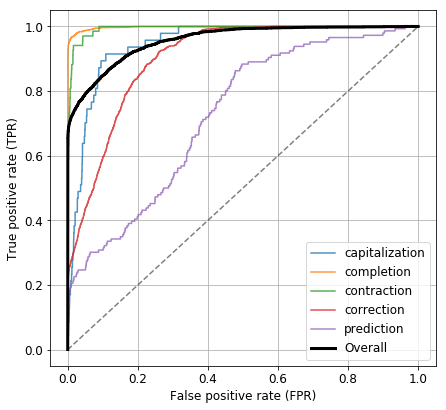

In [12]:
f,ax = plt.subplots(1,1,figsize=(6,5.5))

# 1. Calculate performance for each substrategy

for i in params.columns:
    if i == 'none':
        continue
    
    # Prepare X and y for this substrategy
    mask = (y_test == i) | (y_test == 'none') # Remove instances where other substrategies were used
    X_test_s = X_test.loc[mask]
    y_test_s = y_test.loc[mask] != 'none' # Binary: True when the substrategy is used
   
    # Calculate the probability of using the substrategy on a given word
    y_prob = pd.DataFrame(columns=params.columns)
    X_test_s = sm.add_constant(X_test_s)
    for c in params.columns:
        y_prob[c] = predict_prob(params[c],X_test_s)
    y_prob = y_prob.sum(axis=1) # Probability of using suggestions is the sum of the estimated probability for each substrategy

    fpr, tpr, thresh = metrics.roc_curve(y_test_s, y_prob) 
    
    # Plot ROC
    ax.plot(fpr,tpr, label = i,alpha=0.8)
    
    

# 2. Calculate performance for overall performance

y_test_bool = y_test != 'none' # Binary: True if ANY substrategy was used (rather than a specific one)

# Calculate the probability of using the substrategy on a given word
y_prob = pd.DataFrame(columns=params.columns)
X_test = sm.add_constant(X_test)
for c in params.columns:
    y_prob[c] = predict_prob(params[c],X_test)
y_prob = y_prob.sum(axis=1) # Probability of using suggestions is the sum of the estimated probability for each substrategy


fpr, tpr, thresh = metrics.roc_curve(y_test_bool, y_prob)

# Plot ROC for overall performance
ax.plot(fpr,tpr,label='Overall',lw=3,c='k')
ax.plot([0,1],[0,1],'--',c='k',alpha=0.5)

# 3. Other plot settings
ax.legend(fontsize=12)
ax.grid()
ax.set_xlabel('False positive rate (FPR)')
ax.set_ylabel('True positive rate (TPR)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

f.tight_layout(pad = 0)

f.savefig('./figures/roc_selection.png',dpi=300)

In [13]:
roc = pd.DataFrame([fpr,tpr,thresh]).T
roc.columns = ['fpr','tpr','thresh']
roc = roc.set_index('thresh')
roc.loc[(roc.fpr < 0.1) & (roc.tpr > 0.8)].sample(5, random_state=0)

,fpr,tpr
thresh,,
0.047879,0.075615,0.820563
0.040353,0.096277,0.844466
0.051839,0.066816,0.808775
0.041446,0.092808,0.839227
0.040909,0.094563,0.842829


In [14]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test_bool,y_prob > 0.05))
confusion_matrix

,0,1
0,68861,5238
1,569,2485


In [15]:
metrics.accuracy_score(y_test_bool,y_prob > 0.05)

0.92473397016318226

In [16]:
metrics.precision_score(y_test_bool,y_prob > 0.05)

0.32176615304933315

In [17]:
metrics.recall_score(y_test_bool,y_prob > 0.05)

0.81368696791093653